## Tweet Emotion Recognition: NLP with TensorFlow

## Setup and Imports

Installing Hugging Face's nlp package and importing libraries: 
Dataset: https://huggingface.co/datasets/emotion

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 212 kB 61.2 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

##  Importing Data

Importing the Tweet Emotion dataset
Creating train, validation and test sets
Extracting tweets and labels from the examples

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
train = dataset['train']
val=dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

## Tokenizer

Tokenizing the tweets

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Padding and Truncating Sequences

Checking length of the tweets and creating padded sequences

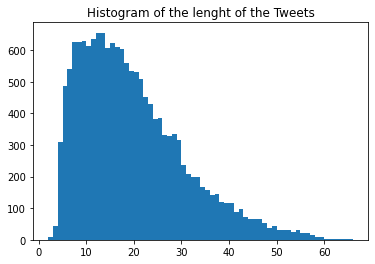

In [12]:
lenghts=[len(t.split(' ')) for t in tweets]
plt.hist(lenghts,bins=len(set(lenghts)))
plt.title('Histogram of the lenght of the Tweets')
plt.show()


In [13]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences 


In [14]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded


In [15]:
padded_train_seq=get_sequences(tokenizer, tweets) 

## Preparing the Labels

Creating classes to index and index to classes dictionaries and converting text labels to numeric labels

In [16]:
classes=set(labels)
print(classes)

{'sadness', 'surprise', 'love', 'fear', 'joy', 'anger'}


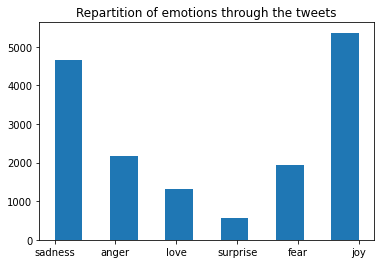

In [18]:
plt.hist(labels, bins=11)
plt.title('Repartition of emotions through the tweets')
plt.show()

In [ ]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())


In [ ]:
class_to_index


{'anger': 0, 'fear': 5, 'joy': 4, 'love': 2, 'sadness': 3, 'surprise': 1}

In [ ]:
index_to_class

{0: 'anger', 1: 'surprise', 2: 'love', 3: 'sadness', 4: 'joy', 5: 'fear'}

In [ ]:
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])

3


## Creating the Model

Creating and compiling the model 

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax'])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam' , 
    metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

Preparing a validation set and training the model

In [ ]:
val_tweets, val_labels =get_tweet(val)
val_seq=get_sequences(tokenizer, val_tweets)
val_labels=names_to_ids(val_labels)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels, 
    validation_data = (val_seq, val_labels), 
    epochs = 20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 19s 18ms/step - loss: 1.3118 - accuracy: 0.4926 - val_loss: 0.8289 - val_accuracy: 0.7010
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.5985 - accuracy: 0.7944 - val_loss: 0.6141 - val_accuracy: 0.7850
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3668 - accuracy: 0.8756 - val_loss: 0.4914 - val_accuracy: 0.8355
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2628 - accuracy: 0.9139 - val_loss: 0.5142 - val_accuracy: 0.8370
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2032 - accuracy: 0.9294 - val_loss: 0.4248 - val_accuracy: 0.8700
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1458 - accuracy: 0.9523 - val_loss: 0.4318 - val_accuracy: 0.8720
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1117 - accuracy: 0.9651 - val_loss: 0.4111 - val_accuracy: 0.889

## Evaluating the Model

Visualizing training history and prepraring a test set

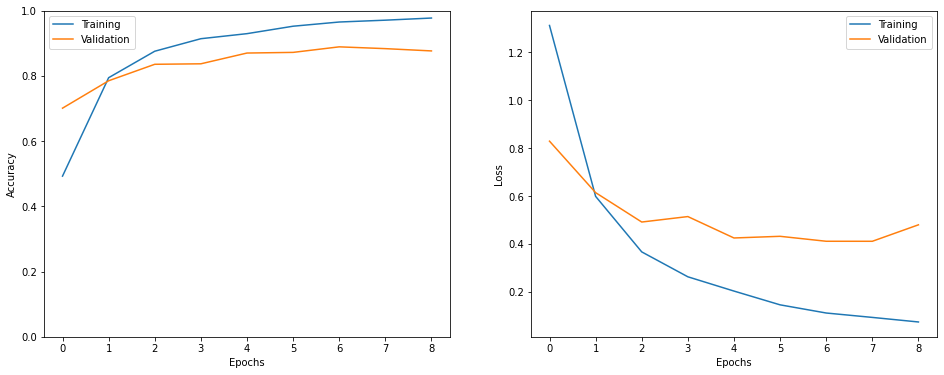

In [ ]:
show_history(h) 


In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 8ms/step - loss: 0.4803 - accuracy: 0.8700


In [ ]:
i = random.randint(0, len(test_labels) - 1)
print('Sentence:' , test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i was studying i always had the feeling that the process was unpleasant but it was absolutely necessary
Emotion: sadness
Predicted Emotion: sadness


In [ ]:
preds = np.argmax(model.predict(test_seq), axis=-1)

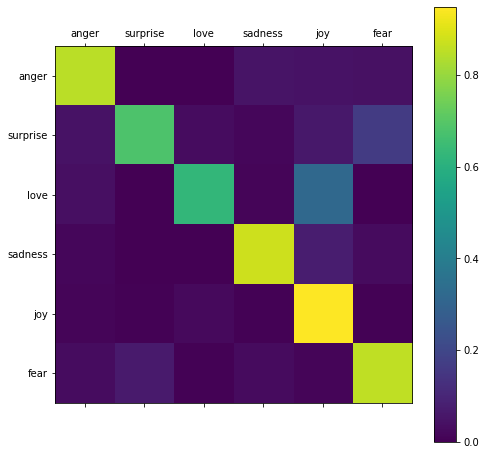

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))
